<a href="https://colab.research.google.com/github/jamesjyoon/llm_interpretability/blob/main/InterpretML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall interpret interpret-community -y
!pip install interpret-community transformers shap  # SHAP is a dependency but explicitly install for safety
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.48.0
    Uninstalling shap-0.48.0:
      Successfully uninstalled shap-0.48.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


  0%|          | 0/1 [00:00<?, ?it/s]

Number of features: 2, Number of values: 2


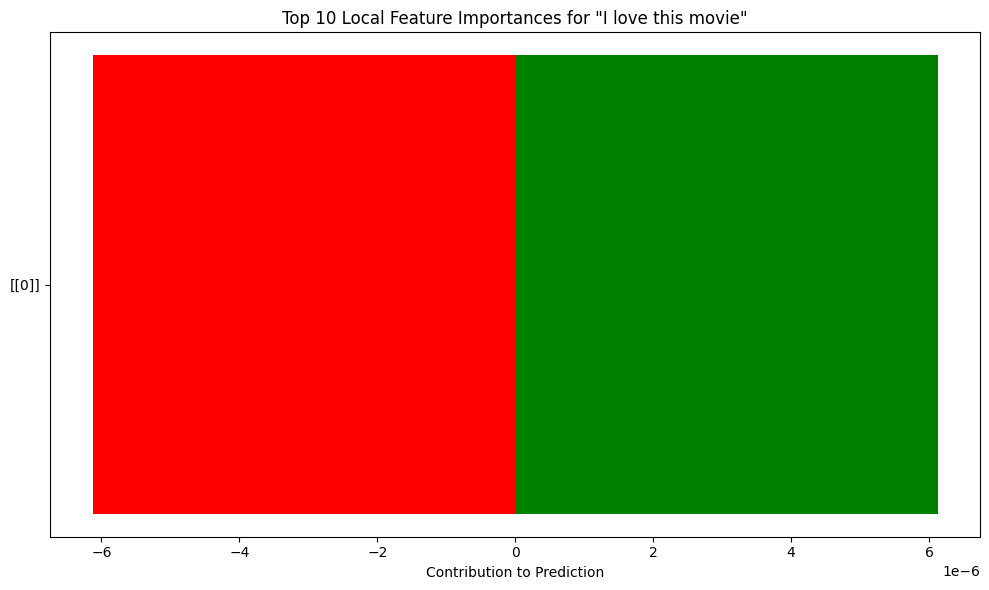

In [ ]:
import numpy as np
from interpret_community.shap.kernel_explainer import KernelExplainer
from transformers import pipeline
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load LLM
llm = pipeline("text-classification", model="distilbert-base-uncased",
               device=0 if torch.cuda.is_available() else -1)

# Robust + batched predict_fn (fixed: always flat list of floats)
def predict_fn(texts):
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        if texts.ndim == 0:
            texts = [str(texts.item())]
        elif texts.ndim == 1:
            texts = [str(t) for t in texts]
        elif texts.ndim == 2 and texts.shape[1] == 1:
            texts = [str(t[0]) for t in texts]
        else:
            raise ValueError(f"Unsupported array shape: {texts.shape}")
    elif isinstance(texts, list):
        texts = [str(t) for t in texts]
    else:
        raise ValueError("Input must be str, list, or np.ndarray")

    results = llm(texts)  # List of dicts (flat for batch/single)
    # Flatten if nested (handles single input case)
    flat_scores = []
    for r in results:
        if isinstance(r, list):  # Nested for single
            flat_scores.append(r[0]["score"])
        else:  # Flat dict
            flat_scores.append(r["score"])
    return flat_scores

# Wrapper class (unchanged)
class BlackBoxModel:
    def __init__(self, predict_fn):
        self.predict_fn = predict_fn
        self.classes_ = [0, 1]

    def predict(self, X):
        scores = np.array(self.predict_fn(X))  # Now always numeric array
        return (scores > 0.5).astype(int)

    def predict_proba(self, X):
        scores = np.array(self.predict_fn(X))
        return np.column_stack([1 - scores, scores])

model = BlackBoxModel(predict_fn)

# Background data
background_data = [
    'My friend plays excitedly.', 'A dog jumps happily.', 'The teacher reads bravely.',
    'The book plays loudly.', 'The teacher reads bravely.', 'The song reads happily.',
    'A child sees quietly.', 'The book watches slowly.', 'The movie hears carefully.',
    'The teacher jumps loudly.', 'The bird watches bravely.', 'The movie plays bravely.',
    'The teacher hears excitedly.', 'The bird watches happily.', 'The movie plays loudly.',
    'The song jumps quietly.', 'The cat jumps excitedly.', 'My friend eats quietly.',
    'The car hears gently.', 'The book jumps quietly.', 'The song hears happily.',
    'The song eats excitedly.', 'A dog sees carefully.', 'The book watches quietly.',
    'The teacher watches slowly.', 'The bird plays sadly.', 'A dog jumps happily.',
    'The cat eats sadly.', 'The movie plays quickly.', 'The movie sees quietly.',
    'The song sees gently.', 'The movie plays quickly.', 'The teacher sees excitedly.',
    'The cat reads bravely.', 'A dog reads gently.', 'A child eats quietly.',
    'The teacher sings loudly.', 'The cat reads carefully.', 'My friend plays loudly.',
    'A dog plays carefully.', 'The bird eats excitedly.', 'The book watches gently.',
    'A child sees loudly.', 'A child hears slowly.', 'The bird watches quietly.',
    'The movie watches quickly.', 'The book sings gently.', 'A child drives sadly.',
    'The car runs bravely.', 'My friend drives quietly.'
]
background = np.expand_dims(np.array(background_data, dtype=object), axis=1)

# Setup explainer
explainer = KernelExplainer(model, background)

# Explain local instance
instance = np.array([["I love this movie"]])
explanation = explainer.explain_local(instance)

# Plot (fixed: deeply flatten the nested list structure)
import matplotlib.pyplot as plt

# Get ranked values and names
ranked_values = explanation.get_ranked_local_values()
ranked_names = explanation.get_ranked_local_names()

# Recursively flatten nested lists
def flatten_value(v):
    while isinstance(v, list) and len(v) > 0:
        v = v[0]
    return float(v)

# Extract first 10 and fully flatten
sorted_values = [flatten_value(v) for v in ranked_values[:10]]
sorted_features = [str(name) for name in ranked_names[:10]]

print(f"Number of features: {len(sorted_features)}, Number of values: {len(sorted_values)}")

# Create color map based on positive/negative contributions
colors = ['green' if v > 0 else 'red' for v in sorted_values]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_values, color=colors)
plt.xlabel('Contribution to Prediction')
plt.title('Top 10 Local Feature Importances for "I love this movie"')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()